# 040 GDAL: mosaicing and masking : Answers to exercises

#### Exercise 1

Recall that the MODIS LAI data need a scaling factor of 0.1 applied, and that values of greater than 100 are invalid.

For the dataset described by:

    kwargs = {
        'product'    : 'MCD15A3H',
        'tile'       : ['h17v03','h18v03'],
        'year'       : 2019,
        'doys'       : [41],
        'sds'        : ['Lai_500m']
    }

* Use `gdal` to read the data into a `numpy` array called lai
* print the shape of the array `lai`
* Find the maximum valid LAI value in the dataset
* find at least one pixel (row, column) which has that maximum value.

You will need to recall how to filter and [mask `numpy` arrays](032_More_numpy.ipynb#argmin,-argmax-and-masking) and use [`np.where`](032_More_numpy.ipynb#where).

In [4]:
# ANSWER
# dont forget to import the packages you need
from osgeo import gdal
import numpy as np
from osgeo import gdal
import numpy as np
from  geog0111.modisUtils import getModisFiles

kwargs = {
    'product'    : 'MCD15A3H',
    'tile'       : ['h17v03','h18v03'],
    'year'       : 2019,
    'doys'       : [41],
    'sds'        : ['Lai_500m']
}
this_sds = data_MCD15A3H['Lai_500m'][41]['h17v03']

# Use gdal to read the data into a numpy array called lai
g = gdal.Open(this_sds)
lai = g.ReadAsArray()
# print the shape of the array `lai`
print(f'shape of lai: {lai.shape}')

shape of lai: (2400, 2400)


In [5]:
# Find the maximum valid LAI value in the dataset
# first filter for valid
valid_mask = (lai <= 100)
# now apply, and scale
max_lai = lai[valid_mask].max()
print(f'max LAI is {max_lai * 0.1}')

# find pixels where it equals the max
where_max_mask = (lai == max_lai)

# find at least one pixel (row, column) 
# which has that maximum value.
row,col = np.where(where_max_mask)
print(row[0],col[0])

max LAI is 7.0
111 2199


#### Exercise 2

* write a function called `stitchModisDate` that you give the arguments:

    * year
    * doy
    
and keywords/defaults:
    
    * sds='Lai_500m'
    * tile=['h17v03','h18v03']
    * product='MCD15A3H'
    
that then generates a stitched VRT file with the appropriate data, and returns the VRT filename. Make sure to use the `year` and `doy` in the VRT filename, along with the tiles, as in the examples above.

Try to design the code so that you could specify multiple doys.

In [13]:
    
def stitchModisDate(year,doy,sds='Lai_500m',\
              tile=['h17v03','h18v03'],\
              product='MCD15A3H'):
    '''
    function called stitchModisDate with arguments:
    
    year
    doy

    keywords/defaults:

        sds      : 'Lai_500m'
        tile     : ['h17v03','h18v03']
        product  : 'MCD15A3H'

    generates a stitched VRT file with the appropriate data,

    returns VRT filename for this dataset.
    '''
    
    kwargs = {
        'product'    : product,
        'tile'       : tile,
        'year'       : year,
        'doys'       : [doy],
        'sds'        : [sds]
    }

    data = getModisFiles(verbose=False,timeout=1000,**kwargs)

    ofiles = []
    
    for sds,sds_v in data.items():
        print('sds',sds)
        for doy,doy_v in sds_v.items():
            print('doy',doy)
            # build a VRT 
            tiles = doy_v.keys()

            ofile = f"work/stitch_{sds}_{kwargs['year']}_{doy:03d}_{'Tiles_'+'_'.join(tiles)}.vrt"
            print(f'saving to {ofile}')    
            stitch_vrt = gdal.BuildVRT(ofile, list(doy_v.values()))
            del stitch_vrt
            ofiles.append(ofile)

    return ofiles[0]

sds Lai_500m
doy 41
saving to work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03.vrt


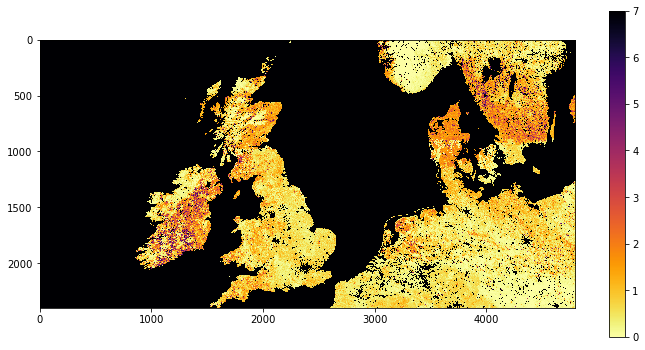

In [14]:
import matplotlib.pyplot as plt

# test
vrtFiles = stitchModisDate(2019,41,sds='Lai_500m')

g = gdal.Open(vrtFiles)
# see if opens
if g:
    fig, axs = plt.subplots(1,1,figsize=(12,6))
    im = axs.imshow(g.ReadAsArray()*0.1,vmax=7,\
                    cmap=plt.cm.inferno_r,interpolation='nearest')
    fig.colorbar(im, ax=axs)
else:
    print('test failed')

#### Exercise 3

* For doy 41 2019, extract and plot LAI of the sub-region around London by defining the approximate pixel coordinates of the area


For doy 41 2019, extract and plot 
LAI of the sub-region around the 
London by defining the 
pixel coordinates of the area

We can identify London from searching for maps.
We can see from the images above and a little trial
and error that this is approximately

r0,r1 = 1900,2150
c0,c1 = 2250,2500




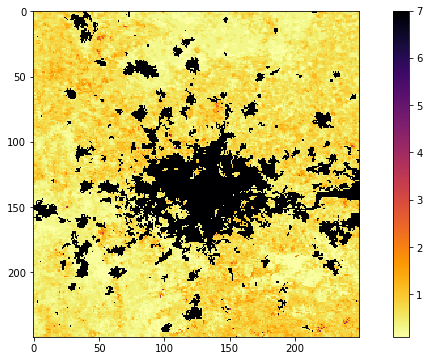

In [18]:
# ANSWER
msg = '''
For doy 41 2019, extract and plot 
LAI of the sub-region around the 
London by defining the 
pixel coordinates of the area

We can identify London from searching for maps.
We can see from the images above and a little trial
and error that this is approximately

r0,r1 = 1900,2150
c0,c1 = 2250,2500

'''

ofile = 'work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04.vrt'
stitch_vrt = gdal.Open(ofile)

# get the lai data as sub-set directly
r0,r1 = 1900,2150
c0,c1 = 2250,2500

london = stitch_vrt.ReadAsArray(c0,r0,c1-c0,r1-r0)*0.1

fig, axs = plt.subplots(1,1,figsize=(12,6))
im = axs.imshow(london,vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
fig.colorbar(im, ax=axs)
print(msg)

#### Exercise 4

* Plot the LAI for Luxemburg (`"FIPS='LU'"`) for doy 46, 2019
* find the mean LAI for Luxemburg for doy 46, 2019 to 2 d.p.


Plot the LAI for Luxemburg ("FIPS='LU'") for doy 46, 2019

This is essentially a straight copy from the notes aboive, changing UK for LU
But if we do that, we will not have the correct tiles to cover Luxemburg
We need to make sure we use ['h18v04','h18v03'] to get the whole country



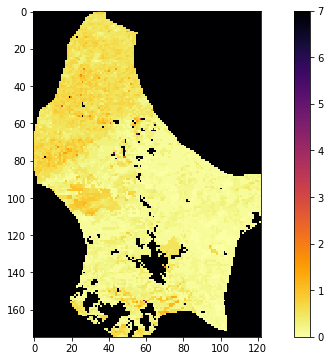

In [21]:
# ANSWER

from osgeo import gdal
from geog0111.modisUtils import getModisFiles,stitchModisDate
import matplotlib.pyplot as plt

msg = '''
Plot the LAI for Luxemburg ("FIPS='LU'") for doy 46, 2019

This is essentially a straight copy from the notes aboive, changing UK for LU
But if we do that, we will not have the correct tiles to cover Luxemburg
We need to make sure we use ['h18v04','h18v03'] to get the whole country
'''

# only choose the tiles we need to make more efficient
# ['h18v04','h18v03']
kwargs = {
    'tile'      :    ['h18v04','h18v03'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',  
    'doy'       :     41,
    'year'      :     2019
}

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='LU'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

vrtFile = stitchModisDate(**kwargs)

# build a VRT 
stitch_vrt = gdal.BuildVRT(vrtFile, kwargs['sds'][0])
del stitch_vrt
# now warp it
g = gdal.Warp("", vrtFile,**warp_args)

fig, axs = plt.subplots(1,1,figsize=(12,6))
im = axs.imshow(g.ReadAsArray()*0.1,vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
fig.colorbar(im, ax=axs)
print(msg)


In [22]:
import numpy as np
msg = '''
Find the mean LAI for Luxemburg for doy 46, 2019 to 2 d.p.

For this part, we need to build a mask of valid data points
Then find the mean LAI over that set.
'''
print(msg)

# dataset scaled
lai = g.ReadAsArray()*0.1

# mask for valid
mask = (lai <= 10.0)

mean_lai = np.mean(lai[mask])

# mean
print(f"Mean LAI for LU for doy {kwargs['doy']} {kwargs['year']} is {mean_lai :.2f}")


Find the mean LAI for Luxemburg for doy 46, 2019 to 2 d.p.

For this part, we need to build a mask of valid data points
Then find the mean LAI over that set.

Mean LAI for LU for doy 41 2019 is 0.35


#### Exercise 5

* Use `getModis` to plot the LAI for France for doy 9, 41 and 49, 2019
* find the median LAI for France for doy 9, 41 and 49, 2019 to 2 d.p.

['work/stitch_Lai_500m_2019_009_Tiles_h17v03_h18v03_h17v04_h18v04_Selektor_FIPS_FR_warp.vrt', 'work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04_Selektor_FIPS_FR_warp.vrt', 'work/stitch_Lai_500m_2019_049_Tiles_h17v03_h18v03_h17v04_h18v04_Selektor_FIPS_FR_warp.vrt'] ['2019-009', '2019-041', '2019-049']

Use Modis.get_modis to plot the LAI for France for doy 9, 41 and 49, 2019

This is mostly a copy from the code in the notes. But again we need
to check the tiles to use. We can find that this should be 
['h17v03','h17v04','h18v03','h18v04']

We also need to change the doy to 9, 41 and 49 !!!

We also need to look up the FIPS code for France, since this 
is not given. This can be found to be "FIPS='FR'" from a quick 
search.



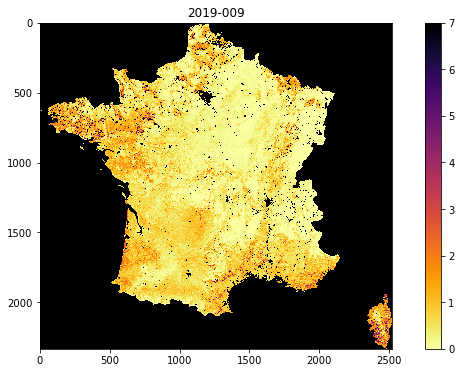

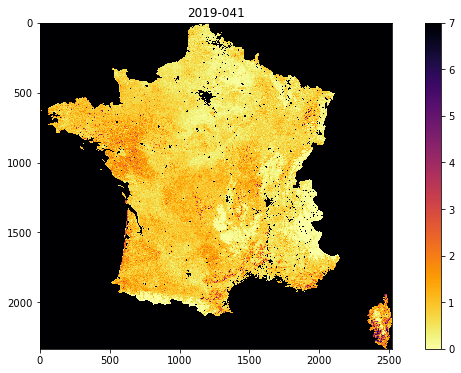

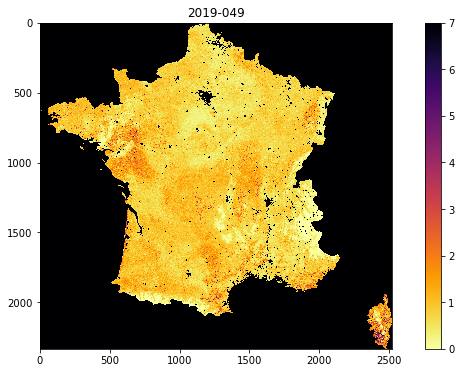

In [25]:
from geog0111.modisUtils import getModis
from osgeo import gdal
import matplotlib.pyplot as plt
#ANSWER

msg = '''
Use Modis.get_modis to plot the LAI for France for doy 9, 41 and 49, 2019

This is mostly a copy from the code in the notes. But again we need
to check the tiles to use. We can find that this should be 
['h17v03','h17v04','h18v03','h18v04']

We also need to change the doy to 9, 41 and 49 !!!

We also need to look up the FIPS code for France, since this 
is not given. This can be found to be "FIPS='FR'" from a quick 
search.
'''
from geog0111.modisUtils import getModis

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='FR'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

kwargs = {
    'tile'      :    ['h17v03','h18v03','h17v04','h18v04'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
    'doys'       : [9,41,49],
    'year'      : 2019,
    'warp_args' : warp_args
}

datafiles,bnames = getModis(verbose=False,timeout=1000,**kwargs)

print(datafiles,bnames)

for datafile,bname in zip(datafiles,bnames):
    g = gdal.Open(datafile)
    fig, axs = plt.subplots(1,1,figsize=(12,6))
    im = axs.imshow(g.ReadAsArray()*0.1,vmax=7,\
                    cmap=plt.cm.inferno_r,interpolation='nearest')
    axs.set_title(bname)
    _=fig.colorbar(im, ax=axs)

print(msg)

In [26]:
import numpy as np
#ANSWER

msg = '''
find the median LAI for France for doy 9, 41 and 49, 2019 to 2 d.p.

Same as above, but notice median is asked for

For this part, we need to build a mask of valid data points
Then find the mean LAI over that set.
'''
print(msg)

for datafile,bname in zip(datafiles,bnames):
    g = gdal.Open(datafile)
    # dataset scaled
    lai = g.ReadAsArray()*0.1

    # mask for valid
    mask = (lai <= 10.0)

    # np.median
    median_lai = np.median(lai[mask])

    # mean
    print(f'Mean LAI for FR for {bname} is {median_lai :.2f}')


find the median LAI for France for doy 9, 41 and 49, 2019 to 2 d.p.

Same as above, but notice median is asked for

For this part, we need to build a mask of valid data points
Then find the mean LAI over that set.

Mean LAI for FR for 2019-009 is 0.40
Mean LAI for FR for 2019-041 is 0.70
Mean LAI for FR for 2019-049 is 0.80
